# Zillow House Price Prediction

## Business Objective Overview

Finding greatest potential locations: This project analyzes top zipcodes in particular counties with high ROI. Fractal clustering is used to group similar neighborhoods together based on their spatial properties and other features. Then, a Gaussian mixture model is used to model the distribution of house prices within each cluster, based on factors such as the size of the house, the number of rooms, and the age of the property.


## Data Understanding

This data represents median monthly housing sales for 3 bedroom homes across the United States. 

Each row represents a unique ZipCode. Each record contains loccation info and median housing sales prices for each month.

There are 23404 rows and 281 variables:

RegionID: Unique index, 
<br />RegionName: Unique Zip Code,
<br />City: City in which the zip code is located,
<br />State: State in which the zip code is located,
<br />Metro: Metropolitan Area in which the zip code is located,
<br />CountyName: County in which the zip code is located,
<br />SizeRank: Numerical rank of size of zip code, ranked 1 through 23404
01-00 through 08-22: refers to the median housing sales values for January 2000 through August 2022, that is 274 data points of monthly data for each zip code

## Import standard packages and data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from datetime import datetime

import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error
from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

# import warnings
# from sklearn.utils.testing import ignore_warnings
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings('ignore')

In [4]:
url = 'https://drive.google.com/file/d/1HfTP590blvZIYS3MhlQyZK3or4lgIGaV/view'
#url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()
# data = pd.read_csv("/content/Zip_zhvi_bdrmcnt_3_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
# data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,96603.0,...,232376.0,236021.0,239693.0,244103.0,249528.0,255561.0,261406.0,266140.0,269363.0,271087.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,163540.0,...,330128.0,334969.0,339733.0,346806.0,355476.0,365971.0,374539.0,379908.0,381471.0,380327.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,87170.0,...,167760.0,169442.0,171444.0,173448.0,175569.0,178832.0,182377.0,185780.0,188090.0,189856.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,324450.0,...,814606.0,815163.0,817786.0,818496.0,823195.0,827059.0,836542.0,842837.0,849412.0,852484.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,279395.0,...,749033.0,750202.0,754601.0,758353.0,764191.0,766694.0,772804.0,778368.0,783167.0,785138.0


Drop all states outside of Texas, and display information regarding columns. 

In [5]:
# data = data[data['State'] == 'TX']
# data.head()
# data.info(verbose=True)

We will drop 'StateName' and 'RegionType' due to redundancy, and 'SizeRank' due to it being irrelevant for analysis. 

In [6]:
# Drop unnecessary columns 
data = data.drop(['RegionID', 'StateName', 'RegionType', 'SizeRank'], axis=1)

# Change name of 'RegionName' to 'ZipCode'
data = data.rename(columns={'RegionName': 'ZipCode'})

In [7]:
data.isna().sum().sum()

1644543

In [8]:
data.shape

(23404, 277)

## Analyze 'ZipCode'

Next we will look at RegionName, this is the zip code.

In [9]:
data.ZipCode.value_counts() 

77449    1
35203    1
39464    1
71430    1
17505    1
        ..
25401    1
74344    1
6120     1
33301    1
50160    1
Name: ZipCode, Length: 23404, dtype: int64

All zipcodes are unique. Changing to string

In [10]:
data.ZipCode = data.ZipCode.astype('string')

In [11]:
data[['ZipCode', 'State']].sort_values(by=['ZipCode'])

,ZipCode,State
4646,10001,NY
137,10002,NY
655,10003,NY
11591,10005,NY
9650,10007,NY
...,...,...
3676,99709,AK
7046,99712,AK
4183,99801,AK
16770,99824,AK


In [12]:
data.ZipCode.count()

23404

## Analyze 'City'

In [13]:
data.City.nunique()

11311

In [14]:
data.City.isna().sum()

1085

In [15]:
data.City.fillna('None', inplace=True)

## Analyze 'Metro'

Fillna with None

In [16]:
print(data.Metro.value_counts())
print(data.Metro.nunique())

New York-Newark-Jersey City, NY-NJ-PA           793
Chicago-Naperville-Elgin, IL-IN-WI              368
Los Angeles-Long Beach-Anaheim, CA              355
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     316
Washington-Arlington-Alexandria, DC-VA-MD-WV    292
                                               ... 
Lamesa, TX                                        1
Connersville, IN                                  1
Portales, NM                                      1
Natchitoches, LA                                  1
Hereford, TX                                      1
Name: Metro, Length: 922, dtype: int64
922


In [17]:
data.Metro.fillna('None', inplace=True)

In [18]:
data.Metro.value_counts()

None                                           4206
New York-Newark-Jersey City, NY-NJ-PA           793
Chicago-Naperville-Elgin, IL-IN-WI              368
Los Angeles-Long Beach-Anaheim, CA              355
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     316
                                               ... 
Zapata, TX                                        1
Craig, CO                                         1
Clovis, NM                                        1
Butte-Silver Bow, MT                              1
Natchitoches, LA                                  1
Name: Metro, Length: 923, dtype: int64

## Analyze 'CountyName'

In [19]:
data.CountyName.value_counts()

Washington County     275
Los Angeles County    268
Jefferson County      260
Montgomery County     215
Franklin County       201
                     ... 
Lanier County           1
Catahoula Parish        1
Brewster County         1
Early County            1
McCone County           1
Name: CountyName, Length: 1705, dtype: int64

In [20]:
data.isna().sum()

ZipCode         0
State           0
City            0
Metro           0
CountyName      0
             ... 
2022-04-30    279
2022-05-31    238
2022-06-30    157
2022-07-31     85
2022-08-31     12
Length: 277, dtype: int64

In [21]:
data.CountyName.fillna('None', inplace=True)

## Drop sales data that have missing values

In [22]:
data[data['2000-01-31'].isna()]

,ZipCode,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
29,94565,CA,Pittsburg,"San Francisco-Oakland-Berkeley, CA",Contra Costa County,NaN,NaN,NaN,NaN,NaN,...,563088.0,568049.0,578143.0,584834.0,594957.0,602028.0,602774.0,597243.0,589975.0,584882.0
32,78521,TX,Brownsville,"Brownsville-Harlingen, TX",Cameron County,NaN,NaN,NaN,NaN,NaN,...,141332.0,143702.0,145785.0,148925.0,151875.0,155071.0,157557.0,160752.0,163829.0,167074.0
41,10456,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Bronx County,NaN,NaN,NaN,NaN,NaN,...,458589.0,463623.0,470458.0,474277.0,475801.0,478393.0,480640.0,484812.0,484884.0,488002.0
44,11219,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,NaN,NaN,NaN,NaN,NaN,...,829604.0,828789.0,828065.0,830625.0,836662.0,843739.0,849336.0,853506.0,857684.0,864057.0
50,77573,TX,League City,"Houston-The Woodlands-Sugar Land, TX",Galveston County,NaN,NaN,NaN,NaN,NaN,...,290825.0,294876.0,297864.0,301136.0,305735.0,312295.0,317528.0,320674.0,321755.0,323265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23399,46799,IN,Zanesville,"Bluffton, IN",Wells County,NaN,NaN,NaN,NaN,NaN,...,157257.0,160065.0,162584.0,165641.0,166776.0,168208.0,169037.0,170919.0,172515.0,174173.0
23400,77451,TX,East Bernard,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,211125.0,211719.0,210235.0,205233.0
23401,14441,NY,Dresden,"Rochester, NY",Yates County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147462.0,149161.0
23402,26576,WV,Farmington,"Fairmont, WV",Marion County,NaN,NaN,NaN,NaN,NaN,...,86012.0,87789.0,89386.0,91390.0,91966.0,93260.0,94337.0,95119.0,95557.0,95880.0


In [33]:
# All zipcodes have some data
data[data['2022-06-30'].isna()]

,ZipCode,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
1057,11237,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1133842.0
5727,37857,TN,Rogersville,"Kingsport-Bristol, TN-VA",Hawkins County,73133.0,73542.0,73512.0,73770.0,73636.0,...,152657.0,155458.0,157304.0,160452.0,162559.0,166128.0,171648.0,NaN,186733.0,192806.0
8071,74003,OK,Bartlesville,"Bartlesville, OK",Washington County,49969.0,49995.0,50338.0,50749.0,51328.0,...,95618.0,97502.0,99215.0,101107.0,102623.0,104657.0,106346.0,NaN,103021.0,101139.0
10647,62201,IL,East Saint Louis,"St. Louis, MO-IL",Saint Clair County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65833.0,67697.0
11097,28128,NC,Norwood,"Albemarle, NC",Stanly County,150767.0,151217.0,151680.0,152798.0,153793.0,...,282503.0,286983.0,291784.0,296154.0,298957.0,NaN,NaN,NaN,NaN,230328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23391,45032,OH,Harveysburg,"Cincinnati, OH-KY-IN",Warren County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200021.0
23393,95419,CA,Camp Meeker,"Santa Rosa-Petaluma, CA",Sonoma County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,633246.0,620842.0
23396,98628,WA,Goldendale,None,Klickitat County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139024.0,140818.0
23397,98522,WA,Chehalis,"Centralia, WA",Lewis County,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,572066.0,574933.0


In [24]:
def melt_data(data):
    melted = pd.melt(data,
                     id_vars=['ZipCode', 'State', 'City', 'Metro', 'CountyName'],
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [25]:
melted_data = melt_data(data)
melted_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4726636 entries, 0 to 6365887
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ZipCode     string        
 1   State       object        
 2   City        object        
 3   Metro       object        
 4   CountyName  object        
 5   Date        datetime64[ns]
 6   value       float64       
dtypes: datetime64[ns](1), float64(1), object(4), string(1)
memory usage: 288.5+ MB


In [26]:
# Make sure the data type of the 'Date' column is datetime
melted_data['Date'] = pd.to_datetime(melted_data['Date'], format='%Y/%m')

# Set the 'Date' columns as index
melted_data.set_index('Date', inplace=True)

melted_data.info

<bound method DataFrame.info of            ZipCode State          City                                  Metro  \
Date                                                                            
2000-01-31   77449    TX          None   Houston-The Woodlands-Sugar Land, TX   
2000-01-31   77494    TX          None   Houston-The Woodlands-Sugar Land, TX   
2000-01-31   79936    TX       El Paso                            El Paso, TX   
2000-01-31   11368    NY      New York  New York-Newark-Jersey City, NY-NJ-PA   
2000-01-31   11385    NY      New York  New York-Newark-Jersey City, NY-NJ-PA   
...            ...   ...           ...                                    ...   
2022-08-31   46799    IN    Zanesville                           Bluffton, IN   
2022-08-31   77451    TX  East Bernard   Houston-The Woodlands-Sugar Land, TX   
2022-08-31   14441    NY       Dresden                          Rochester, NY   
2022-08-31   26576    WV    Farmington                           Fairmont, WV

In [27]:
melted_data.head()

,ZipCode,State,City,Metro,CountyName,value
Date,,,,,,
2000-01-31,77449,TX,None,"Houston-The Woodlands-Sugar Land, TX",Harris County,96603.0
2000-01-31,77494,TX,None,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,163540.0
2000-01-31,79936,TX,El Paso,"El Paso, TX",El Paso County,87170.0
2000-01-31,11368,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,324450.0
2000-01-31,11385,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,279395.0


## EDA on ZipCodes

In [34]:
print('Average home value' ,round(data['2022-08-31'].mean()))

Average home value 346470


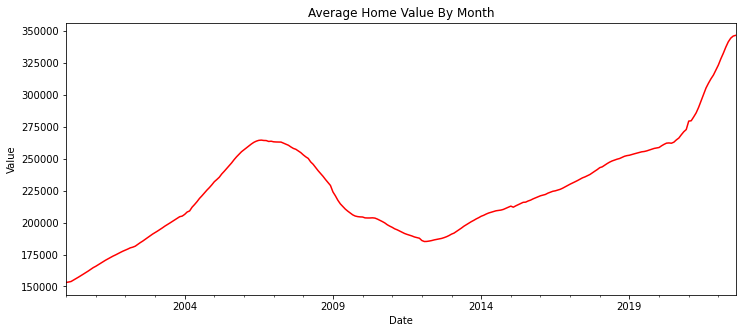

In [35]:
#Average Home Value by Month and Year
month_data = melted_data['value'].resample('MS').mean()
month_data = month_data.fillna(month_data.bfill())
month_data.plot(figsize=(12,5), color='red')
plt.title('Average Home Value By Month')
plt.ylabel('Value')
plt.show()

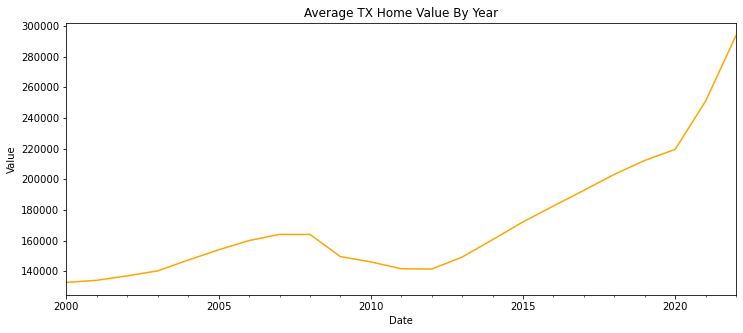

In [ ]:
yr_data = melted_data['value'].resample('A').mean()
yr_data.plot.line(figsize=(12,5), color='orange')
plt.title('Average Home Value By Year')
plt.ylabel('Value')
plt.show()

## Top 10 Metro and County (mean)

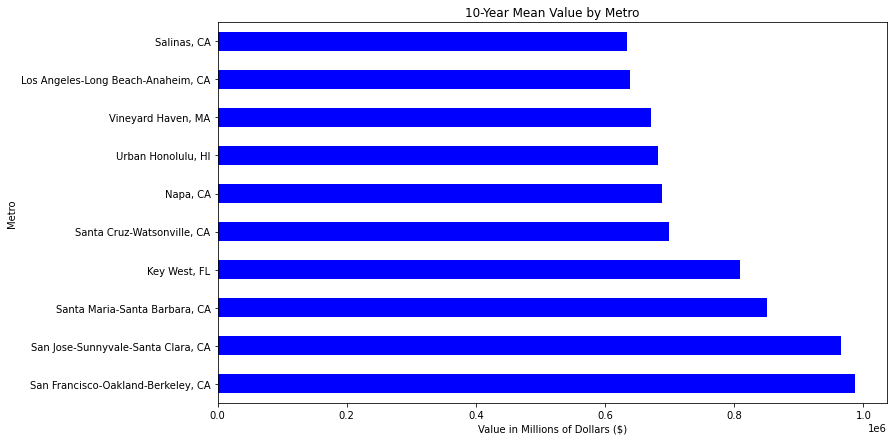

In [36]:
# Get Mean Home Value by metro
metro = melted_data.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

# Plot Mean Home Value by Metro
metro.plot.barh(figsize=(12,7), color='blue')
plt.title('10-Year Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

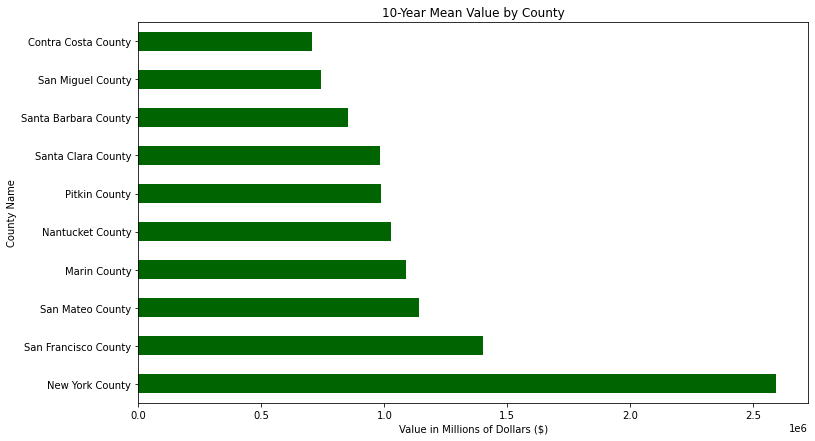

In [37]:
# Get Mean Home Value by County
county = melted_data.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

# Plot Mean Home Value by County
county.plot.barh(figsize = (12,7), color='darkgreen')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

## Most recent one year ROI

In [38]:
# Check out most recent 1 year ROI
data['recent_1_yr_ROI'] = (data['2022-08-31'] - data['2021-08-31'])/(data['2021-08-31'])
data['recent_1_yr_ROI']

0        0.232488
1        0.219513
2        0.182189
3        0.056239
4        0.063654
           ...   
23399    0.132435
23400         NaN
23401         NaN
23402    0.129528
23403    0.170195
Name: recent_1_yr_ROI, Length: 23404, dtype: float64

In [39]:
# Lowest Values
data.sort_values('recent_1_yr_ROI').head()[['ZipCode', 'City', 'recent_1_yr_ROI']]

,ZipCode,City,recent_1_yr_ROI
10302,32626,Chiefland,-0.159863
11097,28128,Norwood,-0.156950
12943,32621,Bronson,-0.155968
10441,63120,Saint Louis,-0.145128
20261,41776,Wooton,-0.143996


In [40]:
# Highest Values 
data.sort_values('recent_1_yr_ROI', ascending=False).head()[['ZipCode', 'City', 'recent_1_yr_ROI']]

,ZipCode,City,recent_1_yr_ROI
11610,44627,Fredericksburg,0.670043
10427,44606,Apple Creek,0.604589
8815,34102,Naples,0.575952
12518,44676,Shreve,0.575068
6636,34114,Naples,0.547776


In [62]:
def average_one_year_ROI(data):
    average_one_year_ROI = []
    for i in range(len(data)):
        year_1_ROI = data['recent_1_yr_ROI'][i]
        year_2_ROI = (data.iloc[i,-15] - data.iloc[i,-27])/data.iloc[i,-27]
        year_3_ROI = (data.iloc[i,-27] - data.iloc[i,-39])/data.iloc[i,-39]
        avg_ROI = (year_1_ROI + year_2_ROI + year_3_ROI)/3
        average_one_year_ROI.append(avg_ROI)
    return average_one_year_ROI   

In [63]:
data['avg_one_yr_ROI'] = average_one_year_ROI(data)

In [64]:
data_top = data[(data['2022-08-31'] < 100000) & (data['avg_one_yr_ROI'] > 0.20)]
data_top

,ZipCode,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,recent_1_yr_ROI,yr_avg,avg_one_yr_ROI
1067,48219,MI,Detroit,"Detroit-Warren-Dearborn, MI",Wayne County,NaN,NaN,NaN,NaN,NaN,...,77786.0,78584.0,80394.0,82735.0,84219.0,84771.0,85091.0,0.125900,55122.635432,0.210870
1530,48224,MI,Detroit,"Detroit-Warren-Dearborn, MI",Wayne County,NaN,NaN,NaN,NaN,NaN,...,74595.0,75671.0,76308.0,77670.0,78634.0,79322.0,79265.0,0.210485,51108.170175,0.221972
2513,48601,MI,Saginaw,"Saginaw, MI",Saginaw County,42620.0,42675.0,42816.0,43020.0,43221.0,...,61496.0,62242.0,63394.0,64096.0,65138.0,65767.0,66539.0,0.203999,43206.270067,0.227292
2879,19132,PA,Philadelphia,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Philadelphia County,19135.0,18942.0,18983.0,19016.0,19210.0,...,86163.0,86559.0,87697.0,88772.0,89930.0,90909.0,91530.0,0.209259,54048.836821,0.254718
3715,48506,MI,None,"Flint, MI",Genesee County,87926.0,87590.0,88038.0,88646.0,89910.0,...,73487.0,74660.0,75504.0,76062.0,76075.0,76547.0,77107.0,0.147016,51540.385784,0.205867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13773,44504,OH,Youngstown,"Youngstown-Warren-Boardman, OH-PA",Mahoning County,51755.0,51320.0,51212.0,51296.0,51570.0,...,69572.0,70406.0,72084.0,73796.0,74820.0,73988.0,72331.0,0.172434,48375.802874,0.236055
13972,17954,PA,Minersville,"Pottsville, PA",Schuylkill County,NaN,NaN,NaN,NaN,NaN,...,61808.0,63626.0,64658.0,64884.0,64807.0,64406.0,64742.0,0.275679,40493.037928,0.261076
16731,17970,PA,Saint Clair,"Pottsville, PA",Schuylkill County,NaN,NaN,NaN,NaN,NaN,...,59403.0,61642.0,63658.0,64502.0,65697.0,65665.0,65831.0,0.300520,41589.755009,0.286353
17157,44510,OH,Youngstown,"Youngstown-Warren-Boardman, OH-PA",Mahoning County,NaN,NaN,NaN,NaN,NaN,...,48135.0,49760.0,50880.0,51361.0,51376.0,50829.0,50465.0,0.179419,34349.452990,0.217102


In [61]:
data_top[['ZipCode', 'City','State','Metro','2022-08-31','avg_one_yr_ROI']]

,ZipCode,City,State,Metro,2022-08-31,avg_one_yr_ROI
1067,48219,Detroit,MI,"Detroit-Warren-Dearborn, MI",85091.0,0.213817
1530,48224,Detroit,MI,"Detroit-Warren-Dearborn, MI",79265.0,0.209770
2513,48601,Saginaw,MI,"Saginaw, MI",66539.0,0.223934
2879,19132,Philadelphia,PA,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",91530.0,0.253381
3725,45417,Dayton,OH,"Dayton-Kettering, OH",64722.0,0.214352
3996,48504,Flint,MI,"Flint, MI",36146.0,0.215758
4336,31206,Macon,GA,"Macon-Bibb County, GA",70769.0,0.248594
4554,43605,Toledo,OH,"Toledo, OH",50093.0,0.225158
4576,48238,Detroit,MI,"Detroit-Warren-Dearborn, MI",57141.0,0.210912
4716,38114,Memphis,TN,"Memphis, TN-MS-AR",95504.0,0.283410


In [70]:
train_df = data.iloc[:,5:275]
train_df['Y'] = data['ZipCode']
train_df = train_df.dropna()
train_df.head(15)

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,Y
0,96603.0,96618.0,96448.0,96469.0,96525.0,96681.0,96773.0,96916.0,97269.0,97495.0,...,229140.0,232376.0,236021.0,239693.0,244103.0,249528.0,255561.0,261406.0,266140.0,77449
1,163540.0,163790.0,164054.0,164736.0,164592.0,164357.0,163287.0,163089.0,162523.0,162956.0,...,324394.0,330128.0,334969.0,339733.0,346806.0,355476.0,365971.0,374539.0,379908.0,77494
2,87170.0,87231.0,87281.0,87299.0,87355.0,87358.0,87355.0,87321.0,86777.0,86149.0,...,165773.0,167760.0,169442.0,171444.0,173448.0,175569.0,178832.0,182377.0,185780.0,79936
6,133522.0,133545.0,133889.0,134658.0,135686.0,136885.0,138103.0,139448.0,140659.0,141864.0,...,244938.0,247985.0,250548.0,253484.0,255487.0,257701.0,259941.0,263459.0,265572.0,60629
7,96608.0,96564.0,96319.0,96256.0,96219.0,96379.0,96407.0,96551.0,96895.0,97217.0,...,224732.0,227606.0,230914.0,234220.0,237989.0,242657.0,247697.0,252703.0,256619.0,77084
8,144773.0,145040.0,145795.0,147167.0,148867.0,150796.0,152912.0,155104.0,156911.0,158351.0,...,653522.0,659038.0,665242.0,669849.0,677464.0,687363.0,700572.0,711423.0,712829.0,91331
9,172932.0,173000.0,173534.0,174565.0,175941.0,177514.0,179214.0,181024.0,182340.0,183331.0,...,634629.0,639038.0,644314.0,649243.0,657427.0,670768.0,687588.0,702447.0,705918.0,90650
10,154747.0,155444.0,155819.0,156901.0,158129.0,159745.0,161124.0,162771.0,164634.0,166954.0,...,469606.0,476719.0,482556.0,488499.0,496963.0,507231.0,517322.0,528628.0,538842.0,8701
12,161035.0,161091.0,161694.0,162619.0,163839.0,165026.0,166247.0,167511.0,168083.0,168583.0,...,581412.0,583078.0,585910.0,588850.0,595543.0,605271.0,618977.0,630980.0,634574.0,90201
13,108996.0,109890.0,110447.0,111717.0,112769.0,113749.0,114516.0,115124.0,115849.0,116782.0,...,488124.0,491535.0,496500.0,503139.0,511656.0,519293.0,527292.0,533159.0,538622.0,92335


In [71]:
train_df.head(15)

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,Y
0,96603.0,96618.0,96448.0,96469.0,96525.0,96681.0,96773.0,96916.0,97269.0,97495.0,...,229140.0,232376.0,236021.0,239693.0,244103.0,249528.0,255561.0,261406.0,266140.0,77449
1,163540.0,163790.0,164054.0,164736.0,164592.0,164357.0,163287.0,163089.0,162523.0,162956.0,...,324394.0,330128.0,334969.0,339733.0,346806.0,355476.0,365971.0,374539.0,379908.0,77494
2,87170.0,87231.0,87281.0,87299.0,87355.0,87358.0,87355.0,87321.0,86777.0,86149.0,...,165773.0,167760.0,169442.0,171444.0,173448.0,175569.0,178832.0,182377.0,185780.0,79936
6,133522.0,133545.0,133889.0,134658.0,135686.0,136885.0,138103.0,139448.0,140659.0,141864.0,...,244938.0,247985.0,250548.0,253484.0,255487.0,257701.0,259941.0,263459.0,265572.0,60629
7,96608.0,96564.0,96319.0,96256.0,96219.0,96379.0,96407.0,96551.0,96895.0,97217.0,...,224732.0,227606.0,230914.0,234220.0,237989.0,242657.0,247697.0,252703.0,256619.0,77084
8,144773.0,145040.0,145795.0,147167.0,148867.0,150796.0,152912.0,155104.0,156911.0,158351.0,...,653522.0,659038.0,665242.0,669849.0,677464.0,687363.0,700572.0,711423.0,712829.0,91331
9,172932.0,173000.0,173534.0,174565.0,175941.0,177514.0,179214.0,181024.0,182340.0,183331.0,...,634629.0,639038.0,644314.0,649243.0,657427.0,670768.0,687588.0,702447.0,705918.0,90650
10,154747.0,155444.0,155819.0,156901.0,158129.0,159745.0,161124.0,162771.0,164634.0,166954.0,...,469606.0,476719.0,482556.0,488499.0,496963.0,507231.0,517322.0,528628.0,538842.0,8701
12,161035.0,161091.0,161694.0,162619.0,163839.0,165026.0,166247.0,167511.0,168083.0,168583.0,...,581412.0,583078.0,585910.0,588850.0,595543.0,605271.0,618977.0,630980.0,634574.0,90201
13,108996.0,109890.0,110447.0,111717.0,112769.0,113749.0,114516.0,115124.0,115849.0,116782.0,...,488124.0,491535.0,496500.0,503139.0,511656.0,519293.0,527292.0,533159.0,538622.0,92335


In [72]:
from sklearn.model_selection import train_test_split
train_df_y = train_df['Y']
train_df = train_df.drop('Y', axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(train_df,train_df_y, test_size=0.33, random_state=4)

In [73]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics 

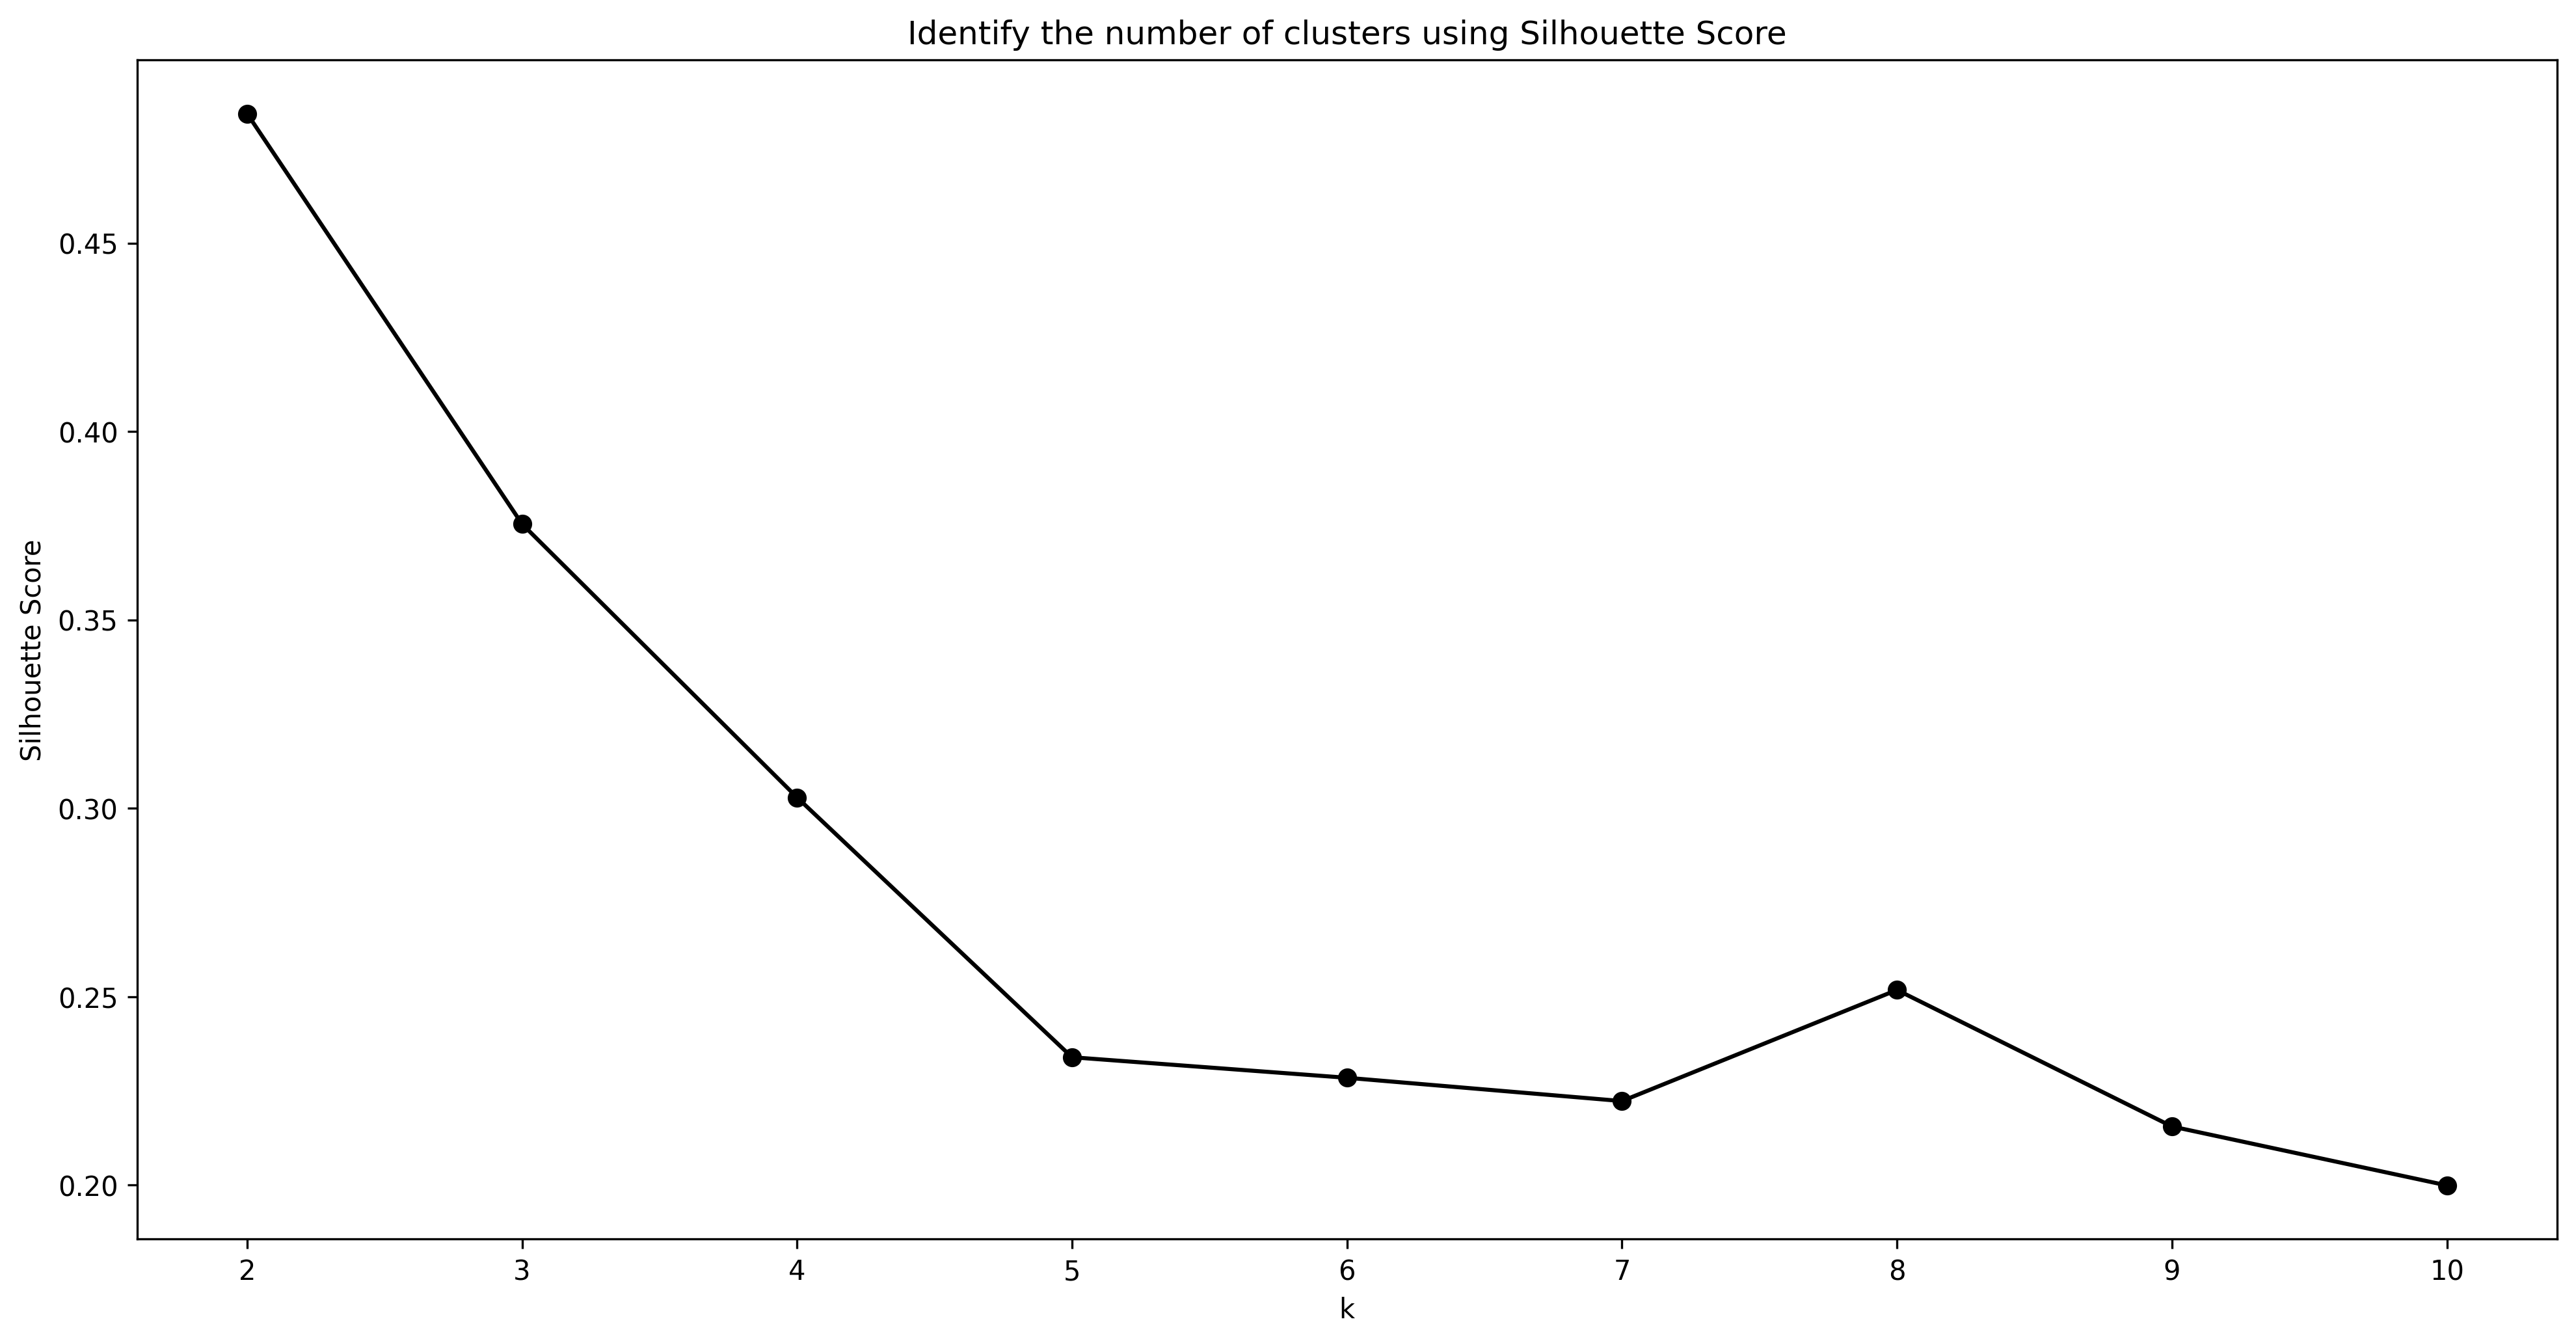

In [74]:
# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans',  reg_covar =1e-2)
    # Fit the model 
    labels = model.fit_predict(X_train)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X_train, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

In [99]:
# Set the model and its parameters - 2 clusters
gmm_model2 = GaussianMixture(n_components=2, 
                         covariance_type='full',
                         max_iter=100, 
                         n_init=1, 
                         init_params='kmeans',
                         verbose=0, 
                         reg_covar =1e-3,
                         random_state=41
                        )

# Fit the model and predict labels
gmm_clust = gmm_model2.fit(X_train)
gmm_labels = gmm_model2.predict(X_test)

# Print model summary
print('*************** 2 Cluster Model ***************')
print('Weights: ', gmm_clust.weights_)
print('Means: ', gmm_clust.means_)
print('Covariances: ', gmm_clust.covariances_)
print('Precisions: ', gmm_clust.precisions_)
print('Precisions Cholesky: ', gmm_clust.precisions_cholesky_)
print('Converged: ', gmm_clust.converged_)
print(' No. of Iterations: ', gmm_clust.n_iter_)
print('Lower Bound: ', gmm_clust.lower_bound_)

*************** 2 Cluster Model ***************
Weights:  [0.78466817 0.21533183]
Means:  [[129942.37098986 130299.31030962 130662.1231843  131409.63179138
  132140.87884929 132877.68616771 133629.06419551 134456.69460495
  135307.77944041 136158.90380593 137023.02544921 137902.80849823
  138720.79411192 139475.21425976 140251.74044497 141098.35995515
  141962.83802677 142818.08541189 143686.04325119 144603.71515446
  145536.83980305 146488.98302664 147383.56760352 148239.7858283
  148993.06469385 149749.69967973 150545.47185537 151426.10971938
  152386.12009339 153389.48204586 154485.81335791 155632.9645486
  156794.92630873 157953.56470982 159060.40160825 160153.97433412
  161173.91418378 162199.1619438  163264.83587286 164406.27918842
  165621.60473589 166825.25382    168064.42487023 169380.13660421
  170770.74834195 172144.78005367 173413.86761157 174612.17580726
  175817.56971659 177127.90652363 178585.06927371 180209.63237629
  182074.87962096 184072.8489894  186193.84716501 1883

### Applying K-Means

In [101]:
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit_predict(X_train)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 9.3 MB/s eta 0:00:00


array([2, 0, 2, ..., 2, 2, 0])

In [102]:
# build helper df to map metrics to their cluster labels
df_cluster = pd.DataFrame(list(zip(X_train.columns, model.labels_)), columns=['metric', 'cluster'])

# make some helper dictionaries and lists
cluster_metrics_dict = df_cluster.groupby(['cluster'])['metric'].apply(lambda x: [x for x in x]).to_dict()
cluster_len_dict = df_cluster['cluster'].value_counts().to_dict()
clusters_dropped = [cluster for cluster in cluster_len_dict if cluster_len_dict[cluster]==1]
clusters_final = [cluster for cluster in cluster_len_dict if cluster_len_dict[cluster]>1]
clusters_final.sort()

df_cluster.head()

,metric,cluster
0,2000-01-31,2
1,2000-02-29,0
2,2000-03-31,2
3,2000-04-30,2
4,2000-05-31,2


In [ ]:
!pip install am4894plots
from am4894plots.plots import plot_lines, plot_lines_grid
for cluster_number in clusters_final:
    # get a rough quality score based on the correlation between metrics in the cluster
    x_corr = data[cluster_metrics_dict[cluster_number]].corr().abs().values
    x_corr_mean = round(x_corr[np.triu_indices(x_corr.shape[0],1)].mean(),2)
    # plot each cluster
    plot_title = f'cluster {cluster_number} (quality={x_corr_mean}, n={cluster_len_dict[cluster_number]})'
    plot_lines(data, cols=cluster_metrics_dict[cluster_number], renderer='colab', theme=None, title=plot_title)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
train_df['Y'] = data['avg_one_yr_ROI']

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
df_train = train_df.iloc[:,1:].dropna()
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit_predict(df_train)

In [ ]:
# build helper df to map metrics to their cluster labels
df_cluster = pd.DataFrame(list(zip(df_train.columns, model.labels_)), columns=['metric', 'cluster'])

# make some helper dictionaries and lists
cluster_metrics_dict = df_cluster.groupby(['cluster'])['metric'].apply(lambda x: [x for x in x]).to_dict()
cluster_len_dict = df_cluster['cluster'].value_counts().to_dict()
clusters_dropped = [cluster for cluster in cluster_len_dict if cluster_len_dict[cluster]==1]
clusters_final = [cluster for cluster in cluster_len_dict if cluster_len_dict[cluster]>1]
clusters_final.sort()

df_cluster.head()

In [ ]:
for cluster_number in clusters_final:
    # get a rough quality score based on the correlation between metrics in the cluster
    x_corr = data[cluster_metrics_dict[cluster_number]].corr().abs().values
    x_corr_mean = round(x_corr[np.triu_indices(x_corr.shape[0],1)].mean(),2)
    # plot each cluster
    plot_title = f'cluster {cluster_number} (quality={x_corr_mean}, n={cluster_len_dict[cluster_number]})'
    plot_lines(df, cols=cluster_metrics_dict[cluster_number], renderer='colab', theme=None, title=plot_title)

#**Conclusions:**

GMM (Gaussian Mixture Model) and K-means are both unsupervised learning algorithms that can be used for clustering analysis of time series data. However, there are some differences between these two algorithms that can impact their suitability for time series data.

K-means is a simple and popular clustering algorithm that partitions data into K clusters based on the distance between the observations. It works well when the clusters are well separated and when the data has low dimensionality. However, time series data often have high dimensionality, and the clusters may not be well separated, making it difficult for K-means to find optimal clusters. Additionally, K-means assumes that the clusters are spherical, which may not be appropriate for time series data.

GMM is a probabilistic clustering algorithm that models the data as a mixture of Gaussian distributions. It is more flexible than K-means because it allows for non-spherical clusters and can handle high-dimensional data. GMM can be especially useful for time series data because it can capture the temporal dependencies of the data, which can be important in many applications. GMM also provides a measure of uncertainty, which can be useful for decision-making in some contexts.

In summary, both K-means and GMM can be used for clustering time series data, but GMM may be more suitable for high-dimensional data with complex cluster structures and temporal dependencies.